In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
import pandas as pd

In [75]:
train_path = "./logs/activation.pt"

In [76]:
ckpt = torch.load(train_path)
fc1 = ckpt["fc1"]
fc1_activations = ckpt["fc1_activations"]
labels = ckpt["labels"]

/tmp/ipykernel_70114/3355228409.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(train_path)


In [77]:
fc1

tensor([[ 8.1721,  8.6419,  4.6956,  ..., -2.0162,  5.1585, -1.7850],
        [ 2.0573,  1.2542,  3.3626,  ..., -1.7315,  1.5306, -1.3794],
        [ 0.7835,  6.8893,  6.8415,  ..., -2.4338,  1.2805, -0.9816],
        ...,
        [ 2.4755,  2.5993,  3.3091,  ..., -1.8202,  4.5090, -1.5915],
        [ 5.7298,  4.3320,  4.6720,  ..., -2.2668,  2.5755, -1.8052],
        [ 2.5707, 11.7011,  6.1637,  ..., -2.7598,  1.4774, -2.0934]],
       requires_grad=True)

In [78]:
fc1_activations

tensor([[ 8.1721,  8.6419,  4.6956,  ...,  0.0000,  5.1585,  0.0000],
        [ 2.0573,  1.2542,  3.3626,  ...,  0.0000,  1.5306,  0.0000],
        [ 0.7835,  6.8893,  6.8415,  ...,  0.0000,  1.2805,  0.0000],
        ...,
        [ 2.4755,  2.5993,  3.3091,  ...,  0.0000,  4.5090,  0.0000],
        [ 5.7298,  4.3320,  4.6720,  ...,  0.0000,  2.5755,  0.0000],
        [ 2.5707, 11.7011,  6.1637,  ...,  0.0000,  1.4774,  0.0000]],
       requires_grad=True)

In [79]:
dataloader = torch.utils.data.DataLoader(TensorDataset(fc1), batch_size=1024, shuffle=True)

In [80]:
print(f"Shape: fc1: {fc1.shape}, fc1_activations: {fc1_activations.shape}, labels: {labels.shape}")

Shape: fc1: torch.Size([60000, 128]), fc1_activations: torch.Size([60000, 128]), labels: torch.Size([60000])


In [81]:
sae = TopKSAE(fc1.shape[-1], nb_concepts=256, top_k=10, device='cuda')

dataloader = torch.utils.data.DataLoader(TensorDataset(fc1), batch_size=1024, shuffle=True)
optimizer = torch.optim.Adam(sae.parameters(), lr=5e-4)

def criterion(x, x_hat, pre_codes, codes, dictionary):
  mse = (x - x_hat).square().mean()
  return mse

logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=20, device='cuda')

Epoch[1/20], Loss: 13.1384, R2: 0.1099, L0: 10.0000, Dead Features: 59.0%, Time: 32.0700 seconds
Epoch[2/20], Loss: 4.3658, R2: 0.7043, L0: 10.0000, Dead Features: 90.2%, Time: 35.1379 seconds
Epoch[3/20], Loss: 2.2174, R2: 0.8499, L0: 10.0000, Dead Features: 50.4%, Time: 36.4933 seconds
Epoch[4/20], Loss: 1.1387, R2: 0.9229, L0: 10.0000, Dead Features: 58.2%, Time: 22.7843 seconds
Epoch[5/20], Loss: 0.7433, R2: 0.9497, L0: 10.0000, Dead Features: 71.1%, Time: 17.9575 seconds
Epoch[6/20], Loss: 0.5677, R2: 0.9616, L0: 10.0000, Dead Features: 70.7%, Time: 18.7407 seconds
Epoch[7/20], Loss: 0.4768, R2: 0.9677, L0: 10.0000, Dead Features: 74.2%, Time: 23.3326 seconds
Epoch[8/20], Loss: 0.4149, R2: 0.9719, L0: 10.0000, Dead Features: 73.8%, Time: 21.3663 seconds
Epoch[9/20], Loss: 0.3731, R2: 0.9747, L0: 9.9997, Dead Features: 79.7%, Time: 20.9433 seconds
Epoch[10/20], Loss: 0.3437, R2: 0.9767, L0: 9.9995, Dead Features: 77.3%, Time: 28.9688 seconds
Epoch[11/20], Loss: 0.3208, R2: 0.9783, 

In [83]:
sae = sae.eval()

with torch.no_grad():
  pre_codes, codes = sae.encode(fc1.to(device))

In [120]:
codes

tensor([[ 0.0000, 15.0082,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.7594,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.4398,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.8154,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 27.3619,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [113]:
activations = pre_codes.cpu()

activations_T = activations.T 

max_vals = activations_T.max(dim=1).values
min_vals = activations_T.min(dim=1).values

df_pre = pd.DataFrame({
    'neuron_id': range(activations_T.shape[0]),
    'max_activation': max_vals.numpy(),
    'min_activation': min_vals.numpy()
})

In [114]:
activations = codes.cpu()

activations_T = activations.T 

max_vals = activations_T.max(dim=1).values
min_vals = activations_T.min(dim=1).values

df = pd.DataFrame({
    'neuron_id': range(activations_T.shape[0]),
    'max_activation': max_vals.numpy(),
    'min_activation': min_vals.numpy()
})

In [121]:
df_filter = df[df.max_activation != 0]

In [136]:
df_filter

,neuron_id,max_activation,min_activation
1,1,38.545635,0.000000
25,25,25.593004,0.000000
27,27,10.498995,0.000000
59,59,1.846075,0.000000
68,68,22.527224,0.000000
81,81,1.560995,0.000000
83,83,12.954467,0.000000
93,93,37.958462,0.000000
106,106,41.904785,0.000000
107,107,19.007902,0.000000


In [126]:
filtered_labels_per_active_neuron = {}

for _, row in df_filter.iterrows():
    neuron_id = int(row['neuron_id'])
    max_val = row['max_activation']
    lower_bound = max_val / 2
    upper_bound = max_val

    mask = (activations[:, neuron_id] >= lower_bound) & (activations[:, neuron_id] <= upper_bound)

    filtered_labels = labels[mask]

    filtered_labels_per_active_neuron[neuron_id] = set(filtered_labels.tolist())

In [127]:
filtered_labels_per_active_neuron

{1: {0, 2, 3, 4, 5, 6, 7, 8, 9},
 25: {2, 3, 4, 5, 6, 7, 8, 9},
 27: {0, 2, 3, 4, 5, 7, 8, 9},
 59: {3, 5, 8},
 68: {0, 2, 4, 5, 6, 8},
 81: {0, 2},
 83: {0, 2, 3, 6, 7, 8, 9},
 93: {1, 2, 4, 5, 7, 8, 9},
 106: {0, 2, 3, 4, 5, 6, 7, 8, 9},
 107: {1, 2, 3, 7, 8},
 112: {0, 1, 2, 3, 5, 7, 8, 9},
 114: {0, 7, 8},
 125: {5, 6},
 129: {5},
 131: {0, 1, 5, 7},
 132: {2},
 134: {0},
 136: {0},
 139: {2},
 143: {0, 1, 2, 3, 4, 5, 6, 8, 9},
 167: {0, 2, 3, 4, 5, 7, 8, 9},
 179: {7},
 197: {3},
 198: {5},
 205: {5},
 208: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 217: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 221: {0, 3, 5, 6, 8, 9},
 229: {5},
 242: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 251: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}

In [128]:
filtered_labels_per_active_neuron = {}

for _, row in df_filter.iterrows():
    neuron_id = int(row['neuron_id'])
    max_val = row['max_activation']
    lower_bound = max_val / 2
    upper_bound = max_val

    mask = (activations[:, neuron_id] >= lower_bound) & (activations[:, neuron_id] <= upper_bound)

    filtered_labels = labels[mask]

    filtered_labels_per_active_neuron[neuron_id] = filtered_labels.tolist()

In [134]:
summary_rows = []

for neuron_id, label_list in filtered_labels_per_active_neuron.items():
    label_counts = pd.Series(label_list).value_counts()
    row = {'neuron_id': neuron_id}
    for class_label in range(10):
        row[class_label] = label_counts.get(class_label, 0)

    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)

In [135]:
summary_df

,neuron_id,0,1,2,3,4,5,6,7,8,9
0,1,4780,0,33,5,65,1012,711,367,2659,3600
1,25,0,0,2073,1333,1963,1461,329,80,2245,2591
2,27,83,0,1,9,40,15,0,143,106,13
3,59,0,0,0,37,0,4,0,0,5,0
4,68,2,0,6,0,4,3,4579,0,3,0
5,81,13,0,8,0,0,0,0,0,0,0
6,83,16,0,519,219,0,0,25,31,1,9
7,93,0,42,4,0,5570,2,0,1219,17,3014
8,106,5036,0,611,13,469,7,766,32,21,64
9,107,0,9,1609,4,0,0,0,118,1,0


In [137]:
merged_df = pd.merge(df_filter, summary_df, on='neuron_id', how='inner')

In [138]:
merged_df

,neuron_id,max_activation,min_activation,0,1,2,3,4,5,6,7,8,9
0,1,38.545635,0.000000,4780,0,33,5,65,1012,711,367,2659,3600
1,25,25.593004,0.000000,0,0,2073,1333,1963,1461,329,80,2245,2591
2,27,10.498995,0.000000,83,0,1,9,40,15,0,143,106,13
3,59,1.846075,0.000000,0,0,0,37,0,4,0,0,5,0
4,68,22.527224,0.000000,2,0,6,0,4,3,4579,0,3,0
5,81,1.560995,0.000000,13,0,8,0,0,0,0,0,0,0
6,83,12.954467,0.000000,16,0,519,219,0,0,25,31,1,9
7,93,37.958462,0.000000,0,42,4,0,5570,2,0,1219,17,3014
8,106,41.904785,0.000000,5036,0,611,13,469,7,766,32,21,64
9,107,19.007902,0.000000,0,9,1609,4,0,0,0,118,1,0


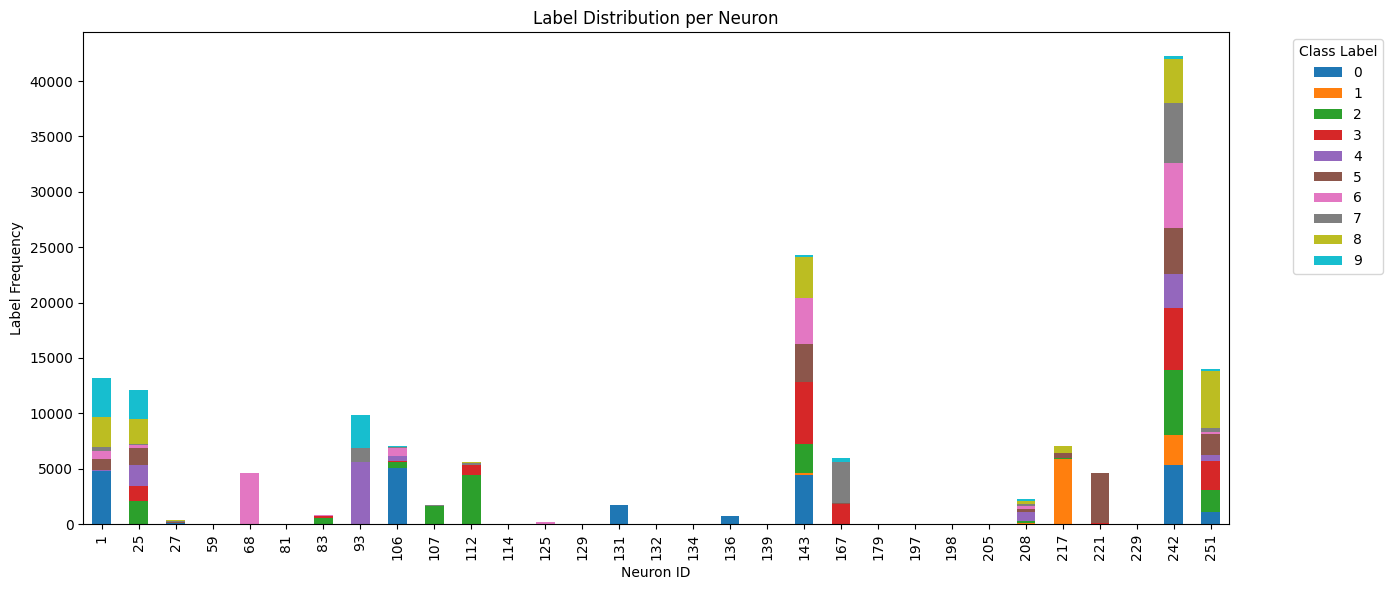

In [141]:
plot_df = merged_df.set_index('neuron_id')

label_columns = [str(i) for i in range(10)] if plot_df.columns[0] == '0' else list(range(10))
label_freqs = plot_df[label_columns]


label_freqs.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    colormap='tab10'
)

plt.xlabel("Neuron ID")
plt.ylabel("Label Frequency")
plt.title("Label Distribution per Neuron")
plt.legend(title="Class Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

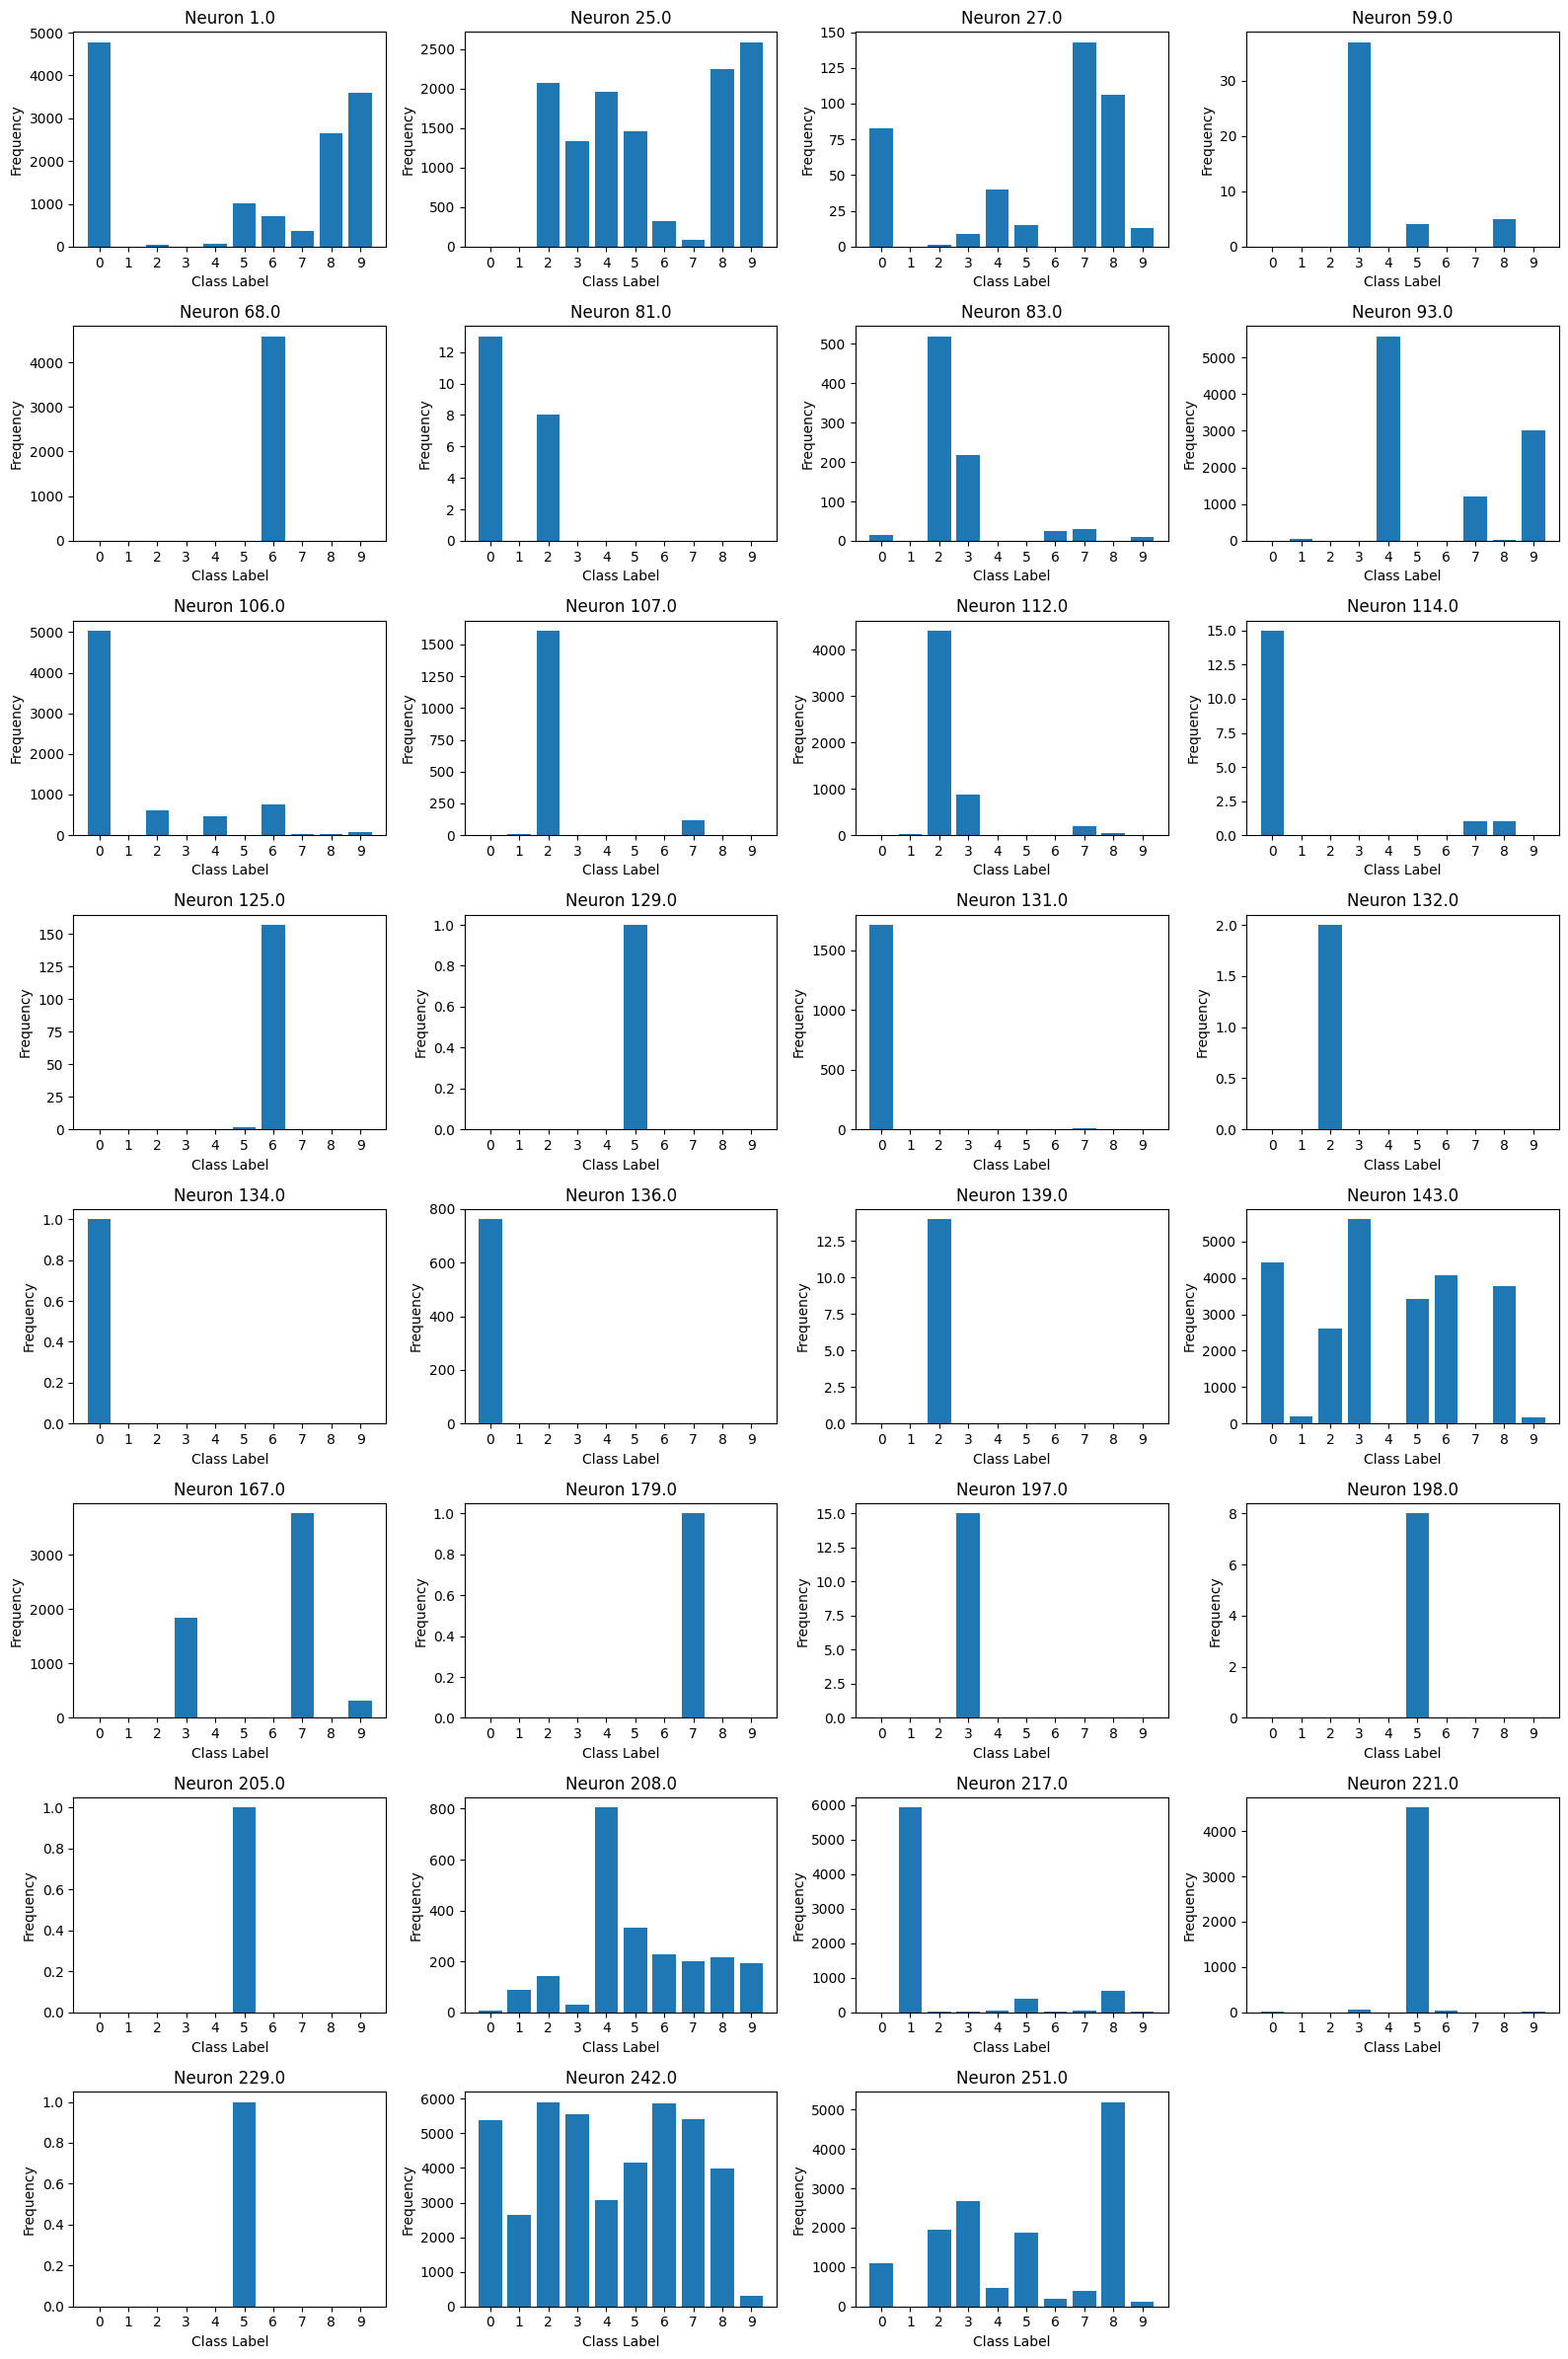

In [140]:
import matplotlib.pyplot as plt

n_neurons = merged_df.shape[0]

n_cols = 4
n_rows = (n_neurons + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))

axes = axes.flatten()

label_cols = list(range(10))  

for idx, row in merged_df.iterrows():
    neuron_id = row['neuron_id']
    label_counts = row[label_cols]

    ax = axes[idx]
    ax.bar(label_cols, label_counts)
    ax.set_title(f'Neuron {neuron_id}')
    ax.set_xticks(label_cols)
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Frequency')

for ax in axes[n_neurons:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
